## Setup script for processing and visualizing SignalAlign accuracy

* Use positions file, variant call output from sa2bed, and reference to give accuracy numbers for modifications


In [1]:
# py3helpers 
from py3helpers.seq_tools import ReferenceHandler
from py3helpers.classification import ClassificationMetrics
# other libs
import pandas as pd
import numpy as np
import matplotlib
# std libs
import os


In [9]:
# paths 
HOME = "/Users/andrewbailey/CLionProjects/personal/projects" 
reference = os.path.join(HOME, "ares_rRNA/reference/yeast_25S_18S.fa")
variant_path = os.path.join(HOME, "ares_rRNA/sa_training/supervised/more_data_ivt_native/variant_calls/ivt.csv")
positions_file = os.path.join(HOME, "ares_rRNA/mod_files/ivt_yeast_18S_25S_mods.positions")

In [10]:
# load positions file
def load_positions_file(path_to_positions_file):
    assert os.path.exists(path_to_positions_file), "Path to positions file does not exist: {}".format(path_to_positions_file)
    return pd.read_csv(path_to_positions_file, sep="\t", names=["contig", "reference_index", "strand", "base", "label"])


#     mods_data = {"RDN18-1": [], "RDN25-1": []}
#     with open(output_mods, 'r') as fh:
#         for line in fh:
#             split_line = line.split()
#             contig = split_line[0]
#             pos = int(split_line[1])
#             strand = split_line[2]
#             find = split_line[3]
#             mods = split_line[4]
#             mods_data[contig].append([pos, strand, find, mods])
#     return mods_data
positions = load_positions_file(positions_file)
positions.head()
assert len(positions) == len("".join(positions["label"])), "Variant label is not in variants at this position. Check model file and positions file"


In [11]:
# load reference
rh = ReferenceHandler(reference)

In [12]:
# load variant data
def load_sa2bed_variant_data(path_to_variant_data):
    assert os.path.exists(path_to_variant_data), "Path to variant data does not exist: {}".format(path_to_variant_data)
    return pd.read_csv(path_to_variant_data)
    
    
variants = load_sa2bed_variant_data(variant_path)
    

In [13]:
variants.head()


,read_id,contig,reference_index,strand,variants,prob1,prob2,prob3
0,043a9f51-5127-4a29-bdfd-5154cf3fa3a7,RDN18-1,973,+,Aa,0.962776,0.037224,NaN
1,043a9f51-5127-4a29-bdfd-5154cf3fa3a7,RDN18-1,998,+,Tl,1.000000,0.000000,NaN
2,043a9f51-5127-4a29-bdfd-5154cf3fa3a7,RDN18-1,1006,+,Cb,1.000000,0.000000,NaN
3,043a9f51-5127-4a29-bdfd-5154cf3fa3a7,RDN18-1,1125,+,Gc,0.000000,1.000000,NaN
4,043a9f51-5127-4a29-bdfd-5154cf3fa3a7,RDN18-1,1180,+,Tl,1.000000,0.000000,NaN


In [24]:
def get_prob_and_label(per_position_variants, positions_df):
    # create probability columns
    prob = per_position_variants[["prob1", "prob2"]].rename(columns={"prob"+str(i+1): value for i, value in enumerate(per_position_variants["variants"].iloc[0])})
    # get label row based on contig, ref_index, and strand
    first_row = per_position_variants.iloc[0]
    label_row = positions_df[(positions_df['contig'] == first_row["contig"]) 
                             & (positions_df['reference_index'] == first_row["reference_index"]) 
                             & (positions_df['strand'] == first_row["strand"])]
    label = label_row.iloc[0]["label"]
    index = first_row["variants"].find(label)
    assert index != -1, "Variant label is not in variants at this position. Check model file and positions file"
    add_to = [0, 0]
    add_to[index] += 1
    label = prob * 0 + add_to
    return label, prob, list(per_position_variants["read_id"])


<IPython.core.display.Javascript object>


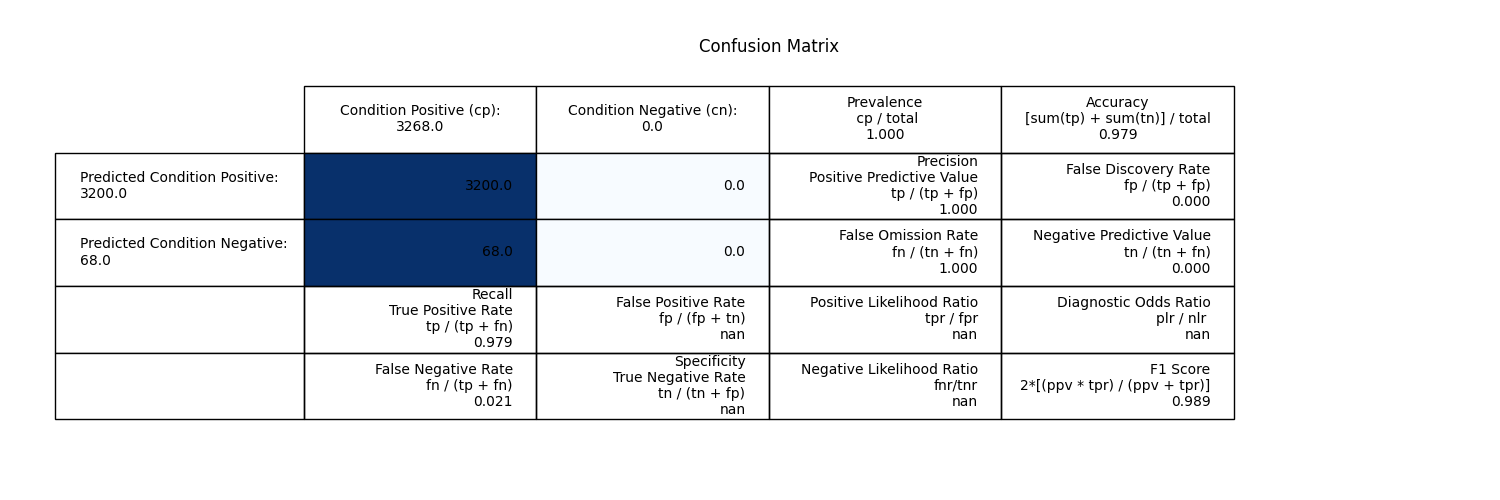

<module 'matplotlib.pyplot' from '/Users/andrewbailey/anaconda3/envs/signalalign/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [25]:
%matplotlib notebook

df_dict = {x: pd.DataFrame(y) for x, y in variants.groupby(['contig','reference_index', "strand", "variants"], as_index=False)}
df_dict2 = {x: pd.DataFrame(y) for x, y in variants.groupby(['contig','reference_index', "strand", "variants"], as_index=False)}

df_dict_list = [df_dict, df_dict2]

d = {}
for key, per_position_variants in df_dict_list[0].items():
    d[key] = tuple(d[key].dropna(1) for d in df_dict_list)
    
for key, per_position_variants in d.items():
    labels = []
    probs = []
    label_ids = []

    for variant in per_position_variants:
        label, prob, label_id = get_prob_and_label(variant, positions)
        labels.append(label)
        probs.append(prob)
        label_ids.extend(label_id)
    
        
    cm = ClassificationMetrics(pd.concat(labels), 
                               pd.concat(probs), 
                               label_ids=label_ids)
    break
cm.plot_confusion_matrix()
# d.head()
          


In [17]:
n_variants = len(variants.columns)-5
label_data = variants[["prob"+str(x+1) for x in range(n_variants)]] * 0
label_data.columns = ["prob"+str(x+1)+"_label" for x in range(n_variants)]
variants2 = pd.concat([variants, label_data], axis=1)
variants2.head()
labelled_dfs = []
for x, y in variants2.groupby(['contig','reference_index', "strand", "variants"], as_index=False):
    label_row = positions[(positions['contig'] == x[0])
                             & (positions['reference_index'] == x[1])
                             & (positions['strand'] == x[2])]
    if len(label_row) == 0:
        print(None, None, None)
        
    first_row = y.iloc[0]
    label = label_row.iloc[0]["label"]
    index = first_row["variants"].find(label)
    assert index != -1, "Variant label is not in variants at this position. Check model file and positions file"
    y.loc[:,"prob"+str(index+1)+"_label"] = 1
    labelled_dfs.append(y)
complete_table = pd.concat(labelled_dfs)
complete_table.head()

/Users/andrewbailey/anaconda3/envs/signalalign/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,read_id,contig,reference_index,strand,variants,prob1,prob2,prob3,prob1_label,prob2_label,prob3_label
100,054a67bc-d272-4e4e-a208-4c5cc1547a06,RDN18-1,27,+,Aa,1.0,0.0,NaN,1,0.0,NaN
131,0070abcc-d478-4464-9136-f5ba8135c25b,RDN18-1,27,+,Aa,1.0,0.0,NaN,1,0.0,NaN
219,0265c81e-b825-4a34-9575-594b89bf1bee,RDN18-1,27,+,Aa,1.0,0.0,NaN,1,0.0,NaN
300,016d7e7c-2b8c-4937-b969-653188c2decd,RDN18-1,27,+,Aa,1.0,0.0,NaN,1,0.0,NaN
334,0504b559-7209-450d-90da-aa82180bc3c3,RDN18-1,27,+,Aa,1.0,0.0,NaN,1,0.0,NaN


In [18]:
def get_prob_and_label(variants):
    # create probability columns
    variant_strings = list(set(variants["variants"]))
    assert len(variant_strings) > 0, "No variant data passed into function get_prob_and_label"
    n_variants = len(variant_strings[0])
    lengths = [len(x) for x in variant_strings]
    if len(variant_strings) > 1:

        assert np.sum(lengths) == lengths[0] * len(lengths), "All modifications must have the " \
                                                                                  "same number of possible variants"
        prob = variants[["prob"+str(x+1) for x in range(n_variants)]].rename(
            columns={"prob" + str(i + 1): value for i, value in enumerate([str(i) for i in range(n_variants)])})
        label = variants[["prob"+str(x+1)+"_label" for x in range(n_variants)]].rename(
            columns={"prob" + str(i + 1)+"_label": value for i, value in enumerate([str(i) for i in range(n_variants)])})

    else:
        prob = variants[["prob"+str(x+1) for x in range(n_variants)]].rename(
            columns={"prob" + str(i + 1): value for i, value in enumerate(variants["variants"].iloc[0])})
        label = variants[["prob"+str(x+1)+"_label" for x in range(n_variants)]].rename(
            columns={"prob" + str(i + 1)+"_label": value for i, value in enumerate(variants["variants"].iloc[0])})

    label_ids = ["_".join([str(y) for y in x]) for x in zip(variants["read_id"],
                                                            variants["contig"],
                                                            variants["reference_index"],
                                                            variants["strand"])]
    return label, prob, label_ids


In [19]:
l, p ,lp = get_prob_and_label(complete_table[complete_table['variants'].str.len() == 2])

possible_variants = list(set(complete_table['variants']))


In [20]:
p.columns[-1]

'1'

In [21]:
complete_table

,read_id,contig,reference_index,strand,variants,prob1,prob2,prob3,prob1_label,prob2_label,prob3_label
100,054a67bc-d272-4e4e-a208-4c5cc1547a06,RDN18-1,27,+,Aa,1.000000,0.000000,NaN,1,0.0,NaN
131,0070abcc-d478-4464-9136-f5ba8135c25b,RDN18-1,27,+,Aa,1.000000,0.000000,NaN,1,0.0,NaN
219,0265c81e-b825-4a34-9575-594b89bf1bee,RDN18-1,27,+,Aa,1.000000,0.000000,NaN,1,0.0,NaN
300,016d7e7c-2b8c-4937-b969-653188c2decd,RDN18-1,27,+,Aa,1.000000,0.000000,NaN,1,0.0,NaN
334,0504b559-7209-450d-90da-aa82180bc3c3,RDN18-1,27,+,Aa,1.000000,0.000000,NaN,1,0.0,NaN
371,034a42c5-6a32-49e3-aba8-ae35ad2a2876,RDN18-1,27,+,Aa,1.000000,0.000000,NaN,1,0.0,NaN
571,03685670-3a48-4361-b021-7f1ac6b072b5,RDN18-1,27,+,Aa,1.000000,0.000000,NaN,1,0.0,NaN
630,03847a4b-717f-4c64-8e34-1f80757c0902,RDN18-1,27,+,Aa,0.986900,0.013100,NaN,1,0.0,NaN
703,045c6a7d-4ab9-4714-8c52-18b894a49aed,RDN18-1,27,+,Aa,1.000000,0.000000,NaN,1,0.0,NaN
740,0547bafc-c492-4eee-9222-20f5e7e4f684,RDN18-1,27,+,Aa,1.000000,0.000000,NaN,1,0.0,NaN
